# BERT Classification

reference: https://velog.io/@jaehyeong/Fine-tuning-Bert-using-Transformers-and-TensorFlow

## 1. Load Dataset

YNAT 쓰라는데 여기서는 sklearn의 20newsgroups 해보겠음

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

dataset_train = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset='train',
    shuffle=True,
)

labels = dataset_train.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset_train.data)} documents - {true_k} categories")
print(list(dataset_train.target_names))
print()

dataset_test = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset='test',
    shuffle=True,
)

labels = dataset_test.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset_test.data)} documents - {true_k} categories")
print(list(dataset_test.target_names))

11314 documents - 20 categories
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

7532 documents - 20 categories
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [2]:
# 참고 블로그랑 변수 맞춰주자
import pandas as pd

dt_labels = [dataset_train.target_names[_] for _ in dataset_train.target]
#print(dataset_train_labels[:10])
train_dataset_list = [{'text':text, 'label':label, 'encoded_label':target} \
                      for text, label, target \
                      in zip(dataset_train.data, dt_labels, dataset_train.target)]
train_df = pd.DataFrame(train_dataset_list)
train_df.head()

#print(type(dataset_train.data[0]), type(dt_labels[0]))

,text,label,encoded_label
0,I was wondering if anyone out there could enli...,rec.autos,7
1,A fair number of brave souls who upgraded thei...,comp.sys.mac.hardware,4
2,"well folks, my mac plus finally gave up the gh...",comp.sys.mac.hardware,4
3,\nDo you have Weitek's address/phone number? ...,comp.graphics,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",sci.space,14


In [3]:
train_df.groupby(by=['label']).count()

,text,encoded_label
label,,
alt.atheism,480,480
comp.graphics,584,584
comp.os.ms-windows.misc,591,591
comp.sys.ibm.pc.hardware,590,590
comp.sys.mac.hardware,578,578
comp.windows.x,593,593
misc.forsale,585,585
rec.autos,594,594
rec.motorcycles,598,598


In [4]:
# 실제랑 맞는지 비교

unique_labels, category_sizes = np.unique(dataset_train.target, return_counts=True)
pd.DataFrame(category_sizes)

,0
0,480
1,584
2,591
3,590
4,578
5,593
6,585
7,594
8,598
9,597


일치함

### Label Encoding

In [5]:
label_encoder_classes_ = dataset_train.target_names

우리는 이미 돼있었던걸 얘는 어쩌구 저쩌구 해서 레이블 인코딩을 하고, train test split도 하고 하는데 그냥 뭐 일단 시키는대로 trainset을 다시 validation set으로 나눠보자

In [6]:
train_texts = train_df["text"].to_list()
train_labels = train_df["encoded_label"].to_list()

In [7]:
from sklearn.model_selection import train_test_split

# Split Train_Set to Actual Training and Validating Data
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=0)

In [8]:
print(len(train_texts), len(val_texts), len(train_labels), len(val_labels))

9051 2263 9051 2263


## 2. Tokenizing the text

이제 본격적인 Transformers 라이브러리 활용

In [9]:
# HUGGINGFACE_MODEL_PATH = "klue/bert-base"

# 우리는 그냥 bert-base-uncased 활용
HUGGINGFACE_MODEL_PATH = "bert-base-uncased"

### Load Tokenizer and Tokenizing

In [10]:
!pip install transformers

In [11]:
from transformers import BertTokenizerFast

# Load Tokenizer
tokenizer_fast = BertTokenizerFast.from_pretrained(HUGGINGFACE_MODEL_PATH)

# Tokenizing
train_encodings_fast = tokenizer_fast(train_texts, truncation=True, padding=True)
val_encodings_fast = tokenizer_fast(val_texts, truncation=True, padding=True)

나는 일반 Tokenizer도 한번 해봄. 성능 비교해보자 한번

In [12]:
from transformers import BertTokenizer

# Load Tokenizer
tokenizer = BertTokenizer.from_pretrained(HUGGINGFACE_MODEL_PATH)

# Tokenizing
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [13]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

In [17]:
dict_train_encodings = dict(train_encodings)
print(type(dict_train_encodings))

<class 'dict'>


## 3. Creating a Dataset object for ~~TensorFlow~~ PyTorch

Tensorflow를 이용해 fine-tuning하려고 변환해주는건데, 나는 transformers의 TFTrainer 활용할거고 앞으로는 PyTorch 쓸거니까 패스할 게 아니라 다 PyTorch용으로 만들어줘야 한다!!

**야호**

오랜 삽질 끝에 찾음 : https://huggingface.co/transformers/v3.4.0/custom_datasets.html#sequence-classification-with-imdb-reviews

이거랑 똑같이, torch.utils.data.Dataset 하위 클래스 하나 만들어서 넣어주면됨.
torch.utils.data.Dataset 요건에 맞게 `__init__`, `__getitem__`, `__len__` 만들어줘야됨.

In [23]:
import torch

class TNGDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

# trainset-set
train_dataset = TNGDataset(train_encodings, train_labels)

# validation-set
val_dataset = TNGDataset(val_encodings, val_labels)

In [26]:
# 되나?!?!?!?!?

print(train_dataset.__len__)

<bound method TNGDataset.__len__ of <__main__.TNGDataset object at 0x12cf3ebe0>>


## 4. Fine-tuning BERT

trainsformers의 ~~TFTrainer~~ Trainer를 활용하는 방법만 사용한다.

### 4.2 Using ~~TFTrainer~~ Trainer class

기세를 몰아 위의 공식문서 따라서 쭉 포팅해보자. PyTorch로 쌉가능이다!(애초에 공식지원이 파이토치인듯)

In [27]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

num_labels = len(label_encoder_classes_)
print("num_labels: ", num_labels)

training_args = TrainingArguments(
    output_dir='./230315BC/results',  # output directory
    num_train_epochs=5,  # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,  # batch size for evaluation
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # strength of weight decay
    logging_dir='./230315BC/logs'  # directory for storing logs
)

trainer_model = BertForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, num_labels=num_labels)
    
trainer = Trainer(
    model = trainer_model,  # the instantiated HugginFace Transformers model to be trained
    args=training_args,  # training arguments, defined above
    train_dataset=train_dataset,  # training dataset
    eval_dataset=val_dataset  # evaluation dataset
)

num_labels:  20


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [28]:
trainer.train()

/Users/jaeha/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9051
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2830
  Number of trainable parameters = 109497620


Step,Training Loss
500,1.986500
1000,0.883200
1500,0.575500
2000,0.348500
2500,0.216000


Saving model checkpoint to ./230315BC/results/checkpoint-500
Configuration saved in ./230315BC/results/checkpoint-500/config.json
Model weights saved in ./230315BC/results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./230315BC/results/checkpoint-1000
Configuration saved in ./230315BC/results/checkpoint-1000/config.json
Model weights saved in ./230315BC/results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./230315BC/results/checkpoint-1500
Configuration saved in ./230315BC/results/checkpoint-1500/config.json
Model weights saved in ./230315BC/results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./230315BC/results/checkpoint-2000
Configuration saved in ./230315BC/results/checkpoint-2000/config.json
Model weights saved in ./230315BC/results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./230315BC/results/checkpoint-2500
Configuration saved in ./230315BC/results/checkpoint-2500/config.json
Model weights saved in ./230315BC/resul

TrainOutput(global_step=2830, training_loss=0.7269764256561603, metrics={'train_runtime': 39717.5859, 'train_samples_per_second': 1.139, 'train_steps_per_second': 0.071, 'total_flos': 1.190901517166592e+16, 'train_loss': 0.7269764256561603, 'epoch': 5.0})

## 5. Saving Model

transformers 제공 `save_pretrained()`메소드 사용
5가지 파일이 저장 위치에 생성되며, 추후 **HuggingFace Model Hub**로 포팅/로드 가능


우리는 trainer, trainer_model에다 학습시켰으니까 일단 model이라고 변수이름 만들고 옮겨주자.

**model에 해당하는 건 trainer_model이였음!!** 

In [44]:
model = trainer_model

In [45]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [55]:
# 여기 'LABEL_X'를 원래 category로 바꿔주면 되겠다
trainer_model.config.id2label
#trainer_model.config.label2id

{0: 'LABEL_0',
 1: 'LABEL_1',
 2: 'LABEL_2',
 3: 'LABEL_3',
 4: 'LABEL_4',
 5: 'LABEL_5',
 6: 'LABEL_6',
 7: 'LABEL_7',
 8: 'LABEL_8',
 9: 'LABEL_9',
 10: 'LABEL_10',
 11: 'LABEL_11',
 12: 'LABEL_12',
 13: 'LABEL_13',
 14: 'LABEL_14',
 15: 'LABEL_15',
 16: 'LABEL_16',
 17: 'LABEL_17',
 18: 'LABEL_18',
 19: 'LABEL_19'}

### Change id2label, label2id in model.config

인코딩된 레이블 디코딩해서 0~20같은 숫자가 아니라 다이렉트로 category string이 나오게 하는건데, 우리는 label_encoder 따로 안만들었으니까 **같은역할하는 기능을 만들어줄게**

In [56]:
import re

for label, id_ in trainer_model.config.label2id.items():
    print(id_, label, label_encoder_classes_[int(re.sub('LABEL_','',label))])

0 LABEL_0 alt.atheism
1 LABEL_1 comp.graphics
2 LABEL_2 comp.os.ms-windows.misc
3 LABEL_3 comp.sys.ibm.pc.hardware
4 LABEL_4 comp.sys.mac.hardware
5 LABEL_5 comp.windows.x
6 LABEL_6 misc.forsale
7 LABEL_7 rec.autos
8 LABEL_8 rec.motorcycles
9 LABEL_9 rec.sport.baseball
10 LABEL_10 rec.sport.hockey
11 LABEL_11 sci.crypt
12 LABEL_12 sci.electronics
13 LABEL_13 sci.med
14 LABEL_14 sci.space
15 LABEL_15 soc.religion.christian
16 LABEL_16 talk.politics.guns
17 LABEL_17 talk.politics.mideast
18 LABEL_18 talk.politics.misc
19 LABEL_19 talk.religion.misc


In [59]:
id2label = model.config.id2label
fixed_id2label = {id : label_encoder_classes_[int(re.sub('LABEL_', '', label))]  for id, label in id2label.items()}
fixed_id2label

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

In [61]:
label2id = model.config.label2id
fixed_label2id = {label_encoder_classes_[int(re.sub('LABEL_', '', label))] : id   for id, label in id2label.items()}
fixed_label2id

{'alt.atheism': 0,
 'comp.graphics': 1,
 'comp.os.ms-windows.misc': 2,
 'comp.sys.ibm.pc.hardware': 3,
 'comp.sys.mac.hardware': 4,
 'comp.windows.x': 5,
 'misc.forsale': 6,
 'rec.autos': 7,
 'rec.motorcycles': 8,
 'rec.sport.baseball': 9,
 'rec.sport.hockey': 10,
 'sci.crypt': 11,
 'sci.electronics': 12,
 'sci.med': 13,
 'sci.space': 14,
 'soc.religion.christian': 15,
 'talk.politics.guns': 16,
 'talk.politics.mideast': 17,
 'talk.politics.misc': 18,
 'talk.religion.misc': 19}

In [64]:
# 잘 고쳐졌으니 반영해주자
model.config.id2label = fixed_id2label
model.config.label2id = fixed_label2id
for label, id_ in trainer_model.config.label2id.items():
    print(id_, label)

0 alt.atheism
1 comp.graphics
2 comp.os.ms-windows.misc
3 comp.sys.ibm.pc.hardware
4 comp.sys.mac.hardware
5 comp.windows.x
6 misc.forsale
7 rec.autos
8 rec.motorcycles
9 rec.sport.baseball
10 rec.sport.hockey
11 sci.crypt
12 sci.electronics
13 sci.med
14 sci.space
15 soc.religion.christian
16 talk.politics.guns
17 talk.politics.mideast
18 talk.politics.misc
19 talk.religion.misc


### Saving the model and tokenizer

In [69]:
import os

MODEL_NAME = 'bert-base-uncased-20newsgroups'
MODEL_SAVE_PATH = os.path.join("230315BC", "soddokayo", MODEL_NAME) # naming~

if os.path.exists(MODEL_SAVE_PATH):
    print(f"{MODEL_SAVE_PATH} -- Folder already exists \n")
else:
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    print(f"{MODEL_SAVE_PATH} -- Folder create complete \n")

230315BC/soddokayo/bert-base-uncased-20newsgroups -- Folder already exists 



In [70]:
# save tokenizer, model
model.save_pretrained(MODEL_SAVE_PATH)

Configuration saved in 230315BC/soddokayo/bert-base-uncased-20newsgroups/config.json
Model weights saved in 230315BC/soddokayo/bert-base-uncased-20newsgroups/pytorch_model.bin


In [71]:
tokenizer.save_pretrained(MODEL_SAVE_PATH)

tokenizer config file saved in 230315BC/soddokayo/bert-base-uncased-20newsgroups/tokenizer_config.json
Special tokens file saved in 230315BC/soddokayo/bert-base-uncased-20newsgroups/special_tokens_map.json


('230315BC/soddokayo/bert-base-uncased-20newsgroups/tokenizer_config.json',
 '230315BC/soddokayo/bert-base-uncased-20newsgroups/special_tokens_map.json',
 '230315BC/soddokayo/bert-base-uncased-20newsgroups/vocab.txt',
 '230315BC/soddokayo/bert-base-uncased-20newsgroups/added_tokens.json')

## 6. Loading the saved Model and Prediction

### Loading the model and tokenizer

In [112]:
from transformers import TextClassificationPipeline

# Load Fine-tuned model
loaded_tokenizer = BertTokenizer.from_pretrained(MODEL_SAVE_PATH)
loaded_model = BertForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer,
    model=loaded_model,
    framework="pt",  # PyTorch:"pt", TensorFlow:"tf"
    return_all_scores=True,  # test case당 모든 레이블에 대한 결과값 다 받고, 
                             # 이따 최상위 하나 고를거임
    truncation=True  # 이거 넣어주니까 길이때매 에러 안난다 ㅋ 512토큰으로 자르는거임
                     # BERT max-length가 512자너
)

loading file vocab.txt
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file 230315BC/soddokayo/bert-base-uncased-20newsgroups/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "alt.atheism",
    "1": "comp.graphics",
    "2": "comp.os.ms-windows.misc",
    "3": "comp.sys.ibm.pc.hardware",
    "4": "comp.sys.mac.hardware",
    "5": "comp.windows.x",
    "6": "misc.forsale",
    "7": "rec.autos",
    "8": "rec.motorcycles",
    "9": "rec.sport.baseball",
    "10": "rec.sport.hockey",
    "11": "sci.crypt",
    "12": "sci.electronics",
    "13": "sci.med",
    "14": "sci.space",
    "15": "soc.religion.christian",
    "16":

### Load Testset

드디어 Test 데이터셋을 로드한다. 우리는 아까 하긴 했는데 다시 불러와보자

In [113]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

dataset_test = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset='test',
    shuffle=True,
)

labels = dataset_test.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset_test.data)} documents - {true_k} categories")
print(list(dataset_test.target_names))

7532 documents - 20 categories
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [114]:
# 참고 블로그랑 변수 맞춰주자
import pandas as pd

dt_labels = [dataset_test.target_names[_] for _ in dataset_test.target]
#print(dataset_test_labels[:10])
test_dataset_list = [{'text':text, 'label':label, 'encoded_label':target} \
                      for text, label, target \
                      in zip(dataset_test.data, dt_labels, dataset_test.target)]
test_df = pd.DataFrame(test_dataset_list)
test_df.head()

#print(type(dataset_test.data[0]), type(dt_labels[0]))

,text,label,encoded_label
0,I am a little confused on all of the models of...,rec.autos,7
1,I'm not familiar at all with the format of the...,comp.windows.x,5
2,"\nIn a word, yes.\n",alt.atheism,0
3,\nThey were attacking the Iraqis to drive them...,talk.politics.mideast,17
4,\nI've just spent two solid months arguing tha...,talk.religion.misc,19


In [115]:
test_df.groupby(by=['label']).count()

,text,encoded_label
label,,
alt.atheism,319,319
comp.graphics,389,389
comp.os.ms-windows.misc,394,394
comp.sys.ibm.pc.hardware,392,392
comp.sys.mac.hardware,385,385
comp.windows.x,395,395
misc.forsale,390,390
rec.autos,396,396
rec.motorcycles,398,398


### Prediction using Pipelines

드디어 모델의 성능평가...! 두근두근

In [120]:
predicted_label_list = []
predicted_score_list = []

for text in test_df['text']:
    # predict
    preds_list = text_classifier(text)[0]
    #print(preds_list)
    
    sorted_preds_list = sorted(preds_list, key=lambda x: x['score'], reverse=True)
    predicted_label_list.append(sorted_preds_list[0]['label']) # label
    predicted_score_list.append(sorted_preds_list[0]['score']) # score
    print(sorted_preds_list[0]['label'], sorted_preds_list[0]['score'])

rec.autos 0.995415449142456
comp.windows.x 0.9719510078430176
talk.politics.misc 0.2888846695423126
alt.atheism 0.9675236344337463
alt.atheism 0.7284786701202393
sci.med 0.9975578784942627
talk.religion.misc 0.4827738404273987
comp.os.ms-windows.misc 0.7580788135528564
comp.windows.x 0.996731162071228
comp.graphics 0.9931176900863647
comp.os.ms-windows.misc 0.9942737221717834
comp.windows.x 0.9963012933731079
talk.politics.mideast 0.9972284436225891
talk.politics.misc 0.3712427318096161
soc.religion.christian 0.9781666994094849
comp.sys.ibm.pc.hardware 0.9859356880187988
comp.sys.mac.hardware 0.993780791759491
comp.sys.mac.hardware 0.5142664313316345
misc.forsale 0.9694265723228455
talk.politics.guns 0.9938494563102722
sci.med 0.9406134486198425
misc.forsale 0.7563551664352417
talk.politics.mideast 0.9650000929832458
sci.space 0.997312068939209
comp.sys.ibm.pc.hardware 0.9909890294075012
sci.med 0.9966593980789185
sci.crypt 0.5663313269615173
rec.autos 0.9956010580062866
rec.autos 0.99

comp.windows.x 0.9966000914573669
sci.electronics 0.9048518538475037
talk.politics.misc 0.5148139595985413
comp.windows.x 0.5664384365081787
comp.sys.mac.hardware 0.6157617568969727
rec.motorcycles 0.9489657878875732
soc.religion.christian 0.9892469048500061
comp.sys.mac.hardware 0.994835615158081
soc.religion.christian 0.8858839869499207
rec.sport.baseball 0.9968639612197876
sci.med 0.9911869168281555
rec.autos 0.9669377207756042
comp.sys.ibm.pc.hardware 0.4856514632701874
rec.autos 0.9960172772407532
rec.autos 0.7310793995857239
rec.sport.hockey 0.9974104762077332
sci.space 0.9973202347755432
comp.graphics 0.9771665334701538
sci.space 0.9527689814567566
sci.electronics 0.6694602966308594
sci.crypt 0.9972180128097534
rec.sport.hockey 0.9110216498374939
soc.religion.christian 0.9887435436248779
misc.forsale 0.9960564374923706
comp.sys.mac.hardware 0.9933323264122009
sci.crypt 0.9971420168876648
misc.forsale 0.9829487800598145
talk.politics.mideast 0.9961912631988525
rec.autos 0.9902511

rec.motorcycles 0.9870965480804443
soc.religion.christian 0.9194977879524231
sci.space 0.9971702694892883
sci.crypt 0.9634875059127808
comp.os.ms-windows.misc 0.6474894881248474
talk.religion.misc 0.6855422854423523
talk.politics.guns 0.7442783117294312
soc.religion.christian 0.9721311330795288
rec.sport.baseball 0.9971445202827454
sci.space 0.9923813939094543
talk.politics.mideast 0.9011254906654358
talk.politics.guns 0.8786413669586182
talk.politics.misc 0.9963485598564148
rec.motorcycles 0.9940033555030823
misc.forsale 0.9965920448303223
soc.religion.christian 0.9891259670257568
sci.med 0.9832013249397278
comp.sys.ibm.pc.hardware 0.9656133055686951
sci.med 0.9969292283058167
rec.autos 0.9960499405860901
rec.sport.baseball 0.9971556663513184
sci.space 0.9934129118919373
comp.graphics 0.42713063955307007
talk.politics.guns 0.972838819026947
misc.forsale 0.8411957025527954
comp.graphics 0.9936844706535339
comp.windows.x 0.9954372048377991
comp.os.ms-windows.misc 0.9906703233718872
sci.

comp.os.ms-windows.misc 0.9948717951774597
sci.med 0.996890127658844
talk.politics.guns 0.9875231385231018
rec.sport.baseball 0.09714990854263306
talk.religion.misc 0.892025351524353
soc.religion.christian 0.9688329100608826
rec.sport.baseball 0.9970821738243103
sci.crypt 0.9767768979072571
rec.autos 0.9744738340377808
talk.politics.mideast 0.4704704284667969
comp.windows.x 0.9967472553253174
comp.sys.ibm.pc.hardware 0.9784964323043823
sci.space 0.995266318321228
comp.windows.x 0.996567964553833
sci.electronics 0.9514129757881165
comp.windows.x 0.989819347858429
talk.religion.misc 0.6695205569267273
talk.politics.guns 0.969980001449585
rec.sport.baseball 0.9877163767814636
sci.electronics 0.9949814677238464
talk.religion.misc 0.6123948693275452
talk.religion.misc 0.7874617576599121
soc.religion.christian 0.9888305068016052
sci.med 0.996806263923645
rec.sport.hockey 0.9975684285163879
comp.sys.mac.hardware 0.993775486946106
soc.religion.christian 0.9881361722946167
talk.politics.guns 0.

comp.graphics 0.9890629649162292
comp.graphics 0.265455961227417
talk.politics.misc 0.9905517101287842
sci.crypt 0.9972710013389587
comp.graphics 0.5568513870239258
rec.motorcycles 0.9971153736114502
sci.electronics 0.9922662377357483
sci.space 0.8103475570678711
sci.space 0.3529245853424072
rec.sport.hockey 0.997526228427887
talk.politics.mideast 0.9970470070838928
sci.crypt 0.9953428506851196
rec.autos 0.9963845014572144
misc.forsale 0.5745072960853577
rec.sport.hockey 0.9969255328178406
sci.crypt 0.9783318042755127
soc.religion.christian 0.9887416958808899
sci.med 0.9921860694885254
talk.politics.guns 0.9827002286911011
talk.politics.mideast 0.9880276918411255
comp.sys.mac.hardware 0.9947891235351562
comp.windows.x 0.9967823028564453
rec.sport.hockey 0.9975488781929016
talk.politics.mideast 0.996239185333252
alt.atheism 0.7168760895729065
soc.religion.christian 0.9897046685218811
comp.sys.ibm.pc.hardware 0.35150209069252014
alt.atheism 0.9296795129776001
rec.motorcycles 0.9971305727

sci.crypt 0.9669040441513062
sci.electronics 0.9702078104019165
comp.sys.ibm.pc.hardware 0.9839828014373779
talk.religion.misc 0.5760997533798218
talk.politics.misc 0.5432923436164856
rec.sport.hockey 0.9975007176399231
rec.autos 0.9959700107574463
sci.med 0.9973892569541931
sci.crypt 0.9972597360610962
comp.sys.ibm.pc.hardware 0.8937930464744568
rec.sport.baseball 0.9971524477005005
rec.sport.baseball 0.9971919655799866
sci.med 0.9970396161079407
comp.graphics 0.9901877045631409
talk.politics.guns 0.5797441601753235
talk.religion.misc 0.7332257628440857
comp.graphics 0.9945755004882812
talk.politics.misc 0.27495312690734863
misc.forsale 0.9747582674026489
sci.crypt 0.9973938465118408
comp.os.ms-windows.misc 0.9940322041511536
talk.politics.guns 0.6740709543228149
talk.politics.mideast 0.9966952800750732
comp.sys.ibm.pc.hardware 0.9632551074028015
rec.sport.hockey 0.9974863529205322
talk.religion.misc 0.547529399394989
comp.sys.ibm.pc.hardware 0.9285770058631897
sci.electronics 0.84493

comp.os.ms-windows.misc 0.992004930973053
sci.space 0.9969335794448853
sci.med 0.9953109622001648
sci.electronics 0.9906394481658936
sci.med 0.9950910806655884
comp.os.ms-windows.misc 0.7566329836845398
rec.sport.baseball 0.09714990854263306
talk.politics.guns 0.9607077240943909
sci.med 0.9973645806312561
comp.windows.x 0.9530792236328125
rec.motorcycles 0.9972139000892639
talk.politics.guns 0.47135770320892334
sci.space 0.9221051335334778
comp.os.ms-windows.misc 0.9911761283874512
comp.windows.x 0.9969373941421509
soc.religion.christian 0.9860052466392517
comp.os.ms-windows.misc 0.986665666103363
sci.space 0.9970881342887878
comp.sys.mac.hardware 0.43934133648872375
rec.sport.baseball 0.9971082806587219
rec.autos 0.9954583644866943
rec.sport.hockey 0.9975705742835999
comp.sys.ibm.pc.hardware 0.9893903136253357
comp.graphics 0.9581168293952942
sci.crypt 0.9972146153450012
soc.religion.christian 0.9857198596000671
sci.space 0.9836894869804382
sci.crypt 0.8353444337844849
talk.politics.m

sci.med 0.9975946545600891
comp.os.ms-windows.misc 0.994211733341217
sci.crypt 0.7535415291786194
talk.politics.mideast 0.997138261795044
comp.graphics 0.5415136218070984
sci.space 0.5000885725021362
misc.forsale 0.9939858317375183
comp.graphics 0.9935322999954224
misc.forsale 0.9970129728317261
sci.space 0.6101340055465698
comp.sys.ibm.pc.hardware 0.608185350894928
soc.religion.christian 0.9610893726348877
sci.electronics 0.5965967774391174
talk.politics.guns 0.628275454044342
rec.sport.baseball 0.09714990854263306
rec.motorcycles 0.9970898032188416
sci.space 0.9938317537307739
sci.med 0.9974583983421326
talk.politics.guns 0.9536252021789551
sci.crypt 0.997327446937561
comp.windows.x 0.9960142374038696
comp.sys.mac.hardware 0.9947766065597534
misc.forsale 0.9947381615638733
sci.crypt 0.9956198334693909
sci.med 0.9949862957000732
sci.electronics 0.3166477084159851
comp.sys.mac.hardware 0.8275717496871948
rec.autos 0.5289072394371033
talk.politics.guns 0.9850910902023315
sci.electronics

misc.forsale 0.9347581267356873
misc.forsale 0.9868966937065125
comp.graphics 0.9917741417884827
soc.religion.christian 0.9848277568817139
soc.religion.christian 0.9860711693763733
sci.electronics 0.7089046239852905
talk.politics.misc 0.9929547905921936
sci.electronics 0.995347797870636
comp.os.ms-windows.misc 0.9934771656990051
sci.med 0.997474730014801
soc.religion.christian 0.9767614603042603
talk.politics.misc 0.995153546333313
comp.sys.ibm.pc.hardware 0.9895920753479004
sci.electronics 0.9773589372634888
rec.sport.baseball 0.9970038533210754
rec.autos 0.8620275259017944
soc.religion.christian 0.9885140061378479
rec.autos 0.9955807328224182
comp.sys.ibm.pc.hardware 0.9896239638328552
sci.crypt 0.9556843042373657
sci.crypt 0.9968554973602295
talk.religion.misc 0.9383403658866882
comp.sys.mac.hardware 0.9894583225250244
comp.windows.x 0.6593484878540039
misc.forsale 0.9877405762672424
comp.graphics 0.8063954710960388
comp.graphics 0.7339575886726379
sci.crypt 0.9974894523620605
sci.c

misc.forsale 0.9514220356941223
sci.med 0.9942173957824707
sci.med 0.9975206255912781
comp.sys.mac.hardware 0.7768025994300842
comp.os.ms-windows.misc 0.9944615960121155
soc.religion.christian 0.9845696091651917
comp.graphics 0.9931077361106873
talk.religion.misc 0.9021492600440979
misc.forsale 0.9696056246757507
rec.motorcycles 0.9970449805259705
sci.space 0.9975893497467041
sci.electronics 0.5492761135101318
sci.crypt 0.9975357055664062
comp.windows.x 0.9968066215515137
misc.forsale 0.9965002536773682
sci.med 0.997505247592926
rec.sport.baseball 0.9969704151153564
misc.forsale 0.9593576788902283
comp.sys.mac.hardware 0.7870393991470337
talk.politics.misc 0.978764533996582
comp.windows.x 0.9357497096061707
rec.sport.hockey 0.9975699782371521
sci.med 0.997097373008728
rec.sport.hockey 0.9975236058235168
sci.med 0.9969397783279419
comp.os.ms-windows.misc 0.9894605278968811
misc.forsale 0.9958702921867371
sci.med 0.9968197345733643
talk.politics.guns 0.9691848754882812
sci.crypt 0.727512

rec.sport.hockey 0.997389018535614
misc.forsale 0.6035305261611938
comp.sys.ibm.pc.hardware 0.9872325658798218
rec.sport.baseball 0.09714990854263306
sci.electronics 0.9703387022018433
sci.electronics 0.9639747738838196
alt.atheism 0.9655972719192505
soc.religion.christian 0.8058754205703735
talk.religion.misc 0.7696804404258728
comp.windows.x 0.9902631044387817
comp.sys.ibm.pc.hardware 0.6078065633773804
misc.forsale 0.9920198321342468
sci.med 0.9975748658180237
rec.motorcycles 0.954698383808136
comp.sys.mac.hardware 0.989462673664093
sci.crypt 0.9974128603935242
comp.sys.mac.hardware 0.9936444759368896
comp.sys.ibm.pc.hardware 0.6649434566497803
comp.os.ms-windows.misc 0.9880948662757874
rec.sport.hockey 0.9972570538520813
comp.graphics 0.9943617582321167
rec.motorcycles 0.9971446394920349
rec.motorcycles 0.7377403974533081
rec.autos 0.9956753849983215
rec.motorcycles 0.9970126152038574
comp.windows.x 0.9967325925827026
soc.religion.christian 0.9826023578643799
rec.autos 0.9960467219

talk.politics.guns 0.995010256767273
misc.forsale 0.9965960383415222
talk.politics.mideast 0.9968632459640503
rec.sport.baseball 0.9970797896385193
rec.motorcycles 0.9633403420448303
soc.religion.christian 0.6421845555305481
rec.sport.hockey 0.9952945113182068
sci.med 0.9972330927848816
talk.politics.misc 0.9957900643348694
talk.religion.misc 0.9545484185218811
sci.med 0.5228587985038757
rec.sport.hockey 0.9976014494895935
talk.religion.misc 0.8903489708900452
sci.med 0.9975461363792419
comp.windows.x 0.9947966933250427
rec.sport.baseball 0.9972399473190308
comp.graphics 0.9919860363006592
misc.forsale 0.9918316006660461
misc.forsale 0.9765046834945679
comp.graphics 0.9885441660881042
talk.religion.misc 0.7705908417701721
rec.sport.baseball 0.09714990854263306
talk.politics.guns 0.9953834414482117
sci.space 0.9866554737091064
rec.sport.baseball 0.9970869421958923
rec.motorcycles 0.29118281602859497
rec.motorcycles 0.9968440532684326
rec.motorcycles 0.9967114925384521
comp.graphics 0.99

comp.sys.ibm.pc.hardware 0.9826447367668152
sci.med 0.980093777179718
talk.religion.misc 0.7892398238182068
rec.sport.hockey 0.9975574016571045
sci.crypt 0.9955637454986572
misc.forsale 0.9953101277351379
rec.sport.hockey 0.9971821308135986
sci.med 0.9974932670593262
comp.windows.x 0.9921773076057434
sci.electronics 0.9853546619415283
sci.crypt 0.9973582625389099
rec.autos 0.8611789345741272
comp.sys.mac.hardware 0.9939495325088501
rec.autos 0.9957504272460938
rec.motorcycles 0.9963719844818115
comp.sys.mac.hardware 0.9930550456047058
rec.sport.baseball 0.9972555041313171
rec.autos 0.9951646327972412
sci.med 0.994529664516449
sci.space 0.9968959093093872
comp.graphics 0.6858304738998413
sci.space 0.996455192565918
soc.religion.christian 0.9853575825691223
talk.politics.misc 0.9963410496711731
sci.med 0.9973512887954712
comp.sys.mac.hardware 0.29536572098731995
sci.space 0.997292697429657
misc.forsale 0.9969660639762878
sci.med 0.9918786287307739
soc.religion.christian 0.912005186080932

rec.motorcycles 0.9970898628234863
sci.crypt 0.9771372675895691
comp.graphics 0.9797812700271606
rec.sport.hockey 0.9975526928901672
comp.sys.mac.hardware 0.9932123422622681
sci.med 0.714654803276062
soc.religion.christian 0.5002639293670654
comp.sys.ibm.pc.hardware 0.9572216272354126
comp.os.ms-windows.misc 0.8288896083831787
talk.politics.mideast 0.6855802536010742
soc.religion.christian 0.9332343935966492
comp.sys.mac.hardware 0.9937792420387268
sci.space 0.9970644116401672
comp.sys.mac.hardware 0.9821797609329224
misc.forsale 0.9963406920433044
sci.electronics 0.9821295142173767
alt.atheism 0.7524088621139526
sci.med 0.850142776966095
rec.sport.hockey 0.9974566102027893
comp.sys.mac.hardware 0.9929342269897461
comp.sys.mac.hardware 0.9949486255645752
talk.politics.guns 0.9806530475616455
rec.autos 0.8949459791183472
comp.graphics 0.9950083494186401
soc.religion.christian 0.9571653008460999
rec.motorcycles 0.9969766139984131
misc.forsale 0.9960909485816956
rec.sport.baseball 0.99717

rec.motorcycles 0.9889329671859741
sci.med 0.9971639513969421
sci.electronics 0.9959569573402405
comp.graphics 0.9888501763343811
talk.politics.guns 0.9705697298049927
comp.windows.x 0.9956139326095581
comp.graphics 0.38736099004745483
rec.motorcycles 0.9972372055053711
talk.politics.mideast 0.99661785364151
talk.politics.mideast 0.7541429400444031
comp.sys.mac.hardware 0.9909071922302246
sci.electronics 0.9956865310668945
comp.os.ms-windows.misc 0.9753308296203613
talk.politics.misc 0.9484635591506958
comp.sys.mac.hardware 0.9918770790100098
rec.sport.baseball 0.09714990854263306
alt.atheism 0.993725597858429
comp.sys.mac.hardware 0.9897850155830383
rec.sport.baseball 0.9960414171218872
rec.sport.baseball 0.9971913695335388
talk.politics.guns 0.990665078163147
sci.med 0.993182361125946
rec.sport.baseball 0.9972598552703857
sci.electronics 0.9940804839134216
rec.autos 0.9964239001274109
misc.forsale 0.6153956651687622
rec.sport.baseball 0.09714990854263306
rec.autos 0.6701746582984924


alt.atheism 0.9170644879341125
sci.space 0.9961400628089905
comp.windows.x 0.5826871395111084
alt.atheism 0.928576648235321
comp.sys.ibm.pc.hardware 0.981728732585907
soc.religion.christian 0.8002884387969971
comp.sys.mac.hardware 0.9674935340881348
rec.motorcycles 0.9971068501472473
sci.crypt 0.9974900484085083
misc.forsale 0.9713205695152283
comp.graphics 0.9942445158958435
sci.electronics 0.7034602165222168
misc.forsale 0.7782971262931824
rec.sport.hockey 0.9973980188369751
comp.sys.ibm.pc.hardware 0.9902570247650146
sci.electronics 0.9866544604301453
rec.autos 0.9957427382469177
comp.os.ms-windows.misc 0.7677908539772034
talk.politics.misc 0.9948486089706421
comp.sys.ibm.pc.hardware 0.9887003302574158
comp.graphics 0.9903691411018372
comp.sys.mac.hardware 0.9936046004295349
rec.motorcycles 0.9963467717170715
talk.politics.mideast 0.9748501777648926
comp.windows.x 0.9956763386726379
rec.sport.baseball 0.09714990854263306
rec.autos 0.9949374198913574
talk.politics.mideast 0.997167289

talk.politics.guns 0.995871365070343
rec.autos 0.6065979599952698
comp.graphics 0.8539511561393738
comp.os.ms-windows.misc 0.9204345941543579
rec.sport.baseball 0.09714990854263306
rec.sport.hockey 0.9974452257156372
rec.sport.baseball 0.9967015385627747
sci.space 0.9975277781486511
misc.forsale 0.4827094078063965
talk.religion.misc 0.9392922520637512
talk.politics.misc 0.9931476712226868
comp.sys.ibm.pc.hardware 0.8391755819320679
comp.os.ms-windows.misc 0.9922661185264587
sci.electronics 0.9956403970718384
comp.graphics 0.9947600960731506
comp.os.ms-windows.misc 0.9050946235656738
soc.religion.christian 0.7664203643798828
sci.space 0.9976454377174377
talk.politics.guns 0.9957291483879089
rec.autos 0.9961807727813721
sci.space 0.9973475933074951
comp.sys.ibm.pc.hardware 0.9077879786491394
sci.crypt 0.9973872303962708
rec.sport.hockey 0.9974958300590515
soc.religion.christian 0.6574198007583618
sci.space 0.9961138963699341
soc.religion.christian 0.9852548837661743
rec.sport.baseball 0.

rec.sport.baseball 0.9972555041313171
rec.sport.hockey 0.9735421538352966
soc.religion.christian 0.9257279634475708
comp.sys.mac.hardware 0.9939576387405396
talk.religion.misc 0.6076597571372986
comp.sys.mac.hardware 0.9936415553092957
talk.religion.misc 0.8917593359947205
talk.politics.misc 0.9331547021865845
talk.politics.misc 0.9752987623214722
talk.politics.guns 0.6179854273796082
talk.religion.misc 0.9178352952003479
sci.med 0.9885936975479126
sci.med 0.9970358610153198
sci.electronics 0.21232926845550537
soc.religion.christian 0.9794899821281433
comp.os.ms-windows.misc 0.99444180727005
comp.sys.mac.hardware 0.9943086504936218
rec.motorcycles 0.9966345429420471
comp.windows.x 0.9966458678245544
rec.sport.baseball 0.4833608567714691
talk.politics.misc 0.5301234722137451
talk.politics.mideast 0.9962486624717712
comp.windows.x 0.9966928958892822
rec.sport.hockey 0.9974852800369263
comp.os.ms-windows.misc 0.9919220209121704
talk.politics.mideast 0.9970322847366333
misc.forsale 0.99467

comp.windows.x 0.9425101280212402
talk.politics.guns 0.9945015907287598
sci.crypt 0.9971593618392944
sci.crypt 0.9973904490470886
alt.atheism 0.7447584271430969
comp.windows.x 0.9967527985572815
rec.motorcycles 0.9971454739570618
talk.politics.mideast 0.9859090447425842
rec.motorcycles 0.9972459077835083
comp.os.ms-windows.misc 0.9908395409584045
misc.forsale 0.873160719871521
comp.graphics 0.9835171699523926
rec.sport.baseball 0.09714990854263306
comp.graphics 0.36139169335365295
comp.sys.mac.hardware 0.6659795641899109
misc.forsale 0.9969168901443481
alt.atheism 0.5975857973098755
talk.politics.misc 0.2597123980522156
comp.sys.ibm.pc.hardware 0.5536324381828308
sci.space 0.9828213453292847
talk.religion.misc 0.7335573434829712
sci.electronics 0.7880985140800476
sci.crypt 0.997458279132843
sci.space 0.9957809448242188
rec.sport.hockey 0.997492790222168
sci.electronics 0.8887413144111633
sci.space 0.9973750114440918
comp.os.ms-windows.misc 0.6253999471664429
rec.sport.baseball 0.997100

alt.atheism 0.993014931678772
comp.os.ms-windows.misc 0.9939625859260559
sci.space 0.9972792267799377
comp.os.ms-windows.misc 0.9917712807655334
talk.politics.guns 0.9873895645141602
rec.autos 0.9671768546104431
misc.forsale 0.37846723198890686
soc.religion.christian 0.987857460975647
comp.sys.ibm.pc.hardware 0.9904466867446899
rec.sport.hockey 0.33321335911750793
talk.politics.mideast 0.9879635572433472
comp.graphics 0.9946877956390381
soc.religion.christian 0.9693266153335571
comp.graphics 0.9929243326187134
rec.motorcycles 0.9949414134025574
sci.med 0.9973011612892151
soc.religion.christian 0.9887393712997437
talk.religion.misc 0.9493489861488342
talk.politics.misc 0.3100592792034149
misc.forsale 0.9969171285629272
misc.forsale 0.5633186101913452
talk.politics.misc 0.9482083916664124
soc.religion.christian 0.9866037368774414
comp.graphics 0.9951830506324768
comp.os.ms-windows.misc 0.994862973690033
comp.graphics 0.9940985441207886
rec.sport.baseball 0.09714990854263306
sci.crypt 0.9

comp.sys.ibm.pc.hardware 0.5473380088806152
comp.graphics 0.7910201549530029
comp.sys.ibm.pc.hardware 0.9890810251235962
sci.crypt 0.5625425577163696
comp.graphics 0.6570643782615662
misc.forsale 0.9873506426811218
comp.sys.mac.hardware 0.9936758875846863
comp.os.ms-windows.misc 0.9721726775169373
rec.autos 0.7694981098175049
rec.sport.hockey 0.9661150574684143
talk.politics.misc 0.8284686803817749
comp.windows.x 0.9929116368293762
comp.sys.ibm.pc.hardware 0.4685564339160919
comp.sys.mac.hardware 0.9938003420829773
rec.sport.baseball 0.3261288106441498
rec.sport.baseball 0.09714990854263306
alt.atheism 0.39960068464279175
rec.motorcycles 0.997088611125946
soc.religion.christian 0.9730706810951233
comp.sys.ibm.pc.hardware 0.986213743686676
alt.atheism 0.6780858039855957
comp.graphics 0.9940702319145203
comp.graphics 0.6409390568733215
sci.crypt 0.9974385499954224
talk.politics.guns 0.6921639442443848
sci.med 0.9974242448806763
comp.sys.mac.hardware 0.9877811670303345
sci.space 0.9973689

talk.religion.misc 0.9394375681877136
talk.politics.mideast 0.9962205290794373
talk.politics.misc 0.833940863609314
comp.graphics 0.9935445785522461
alt.atheism 0.9900482892990112
rec.motorcycles 0.9573490023612976
alt.atheism 0.34842386841773987
talk.politics.guns 0.9863110184669495
alt.atheism 0.7946511507034302
sci.electronics 0.8117692470550537
rec.sport.baseball 0.9970622658729553
rec.motorcycles 0.9964861869812012
sci.crypt 0.9973025321960449
rec.sport.baseball 0.9972401857376099
talk.politics.mideast 0.9958733916282654
talk.politics.guns 0.940926194190979
talk.politics.mideast 0.7619197368621826
talk.religion.misc 0.753027081489563
comp.graphics 0.9534856081008911
misc.forsale 0.9946221113204956
sci.med 0.6598577499389648
talk.politics.guns 0.9958257675170898
rec.autos 0.9961686730384827
sci.med 0.9973898530006409
sci.crypt 0.9972169399261475
sci.crypt 0.9892851710319519
comp.graphics 0.9896256327629089
sci.crypt 0.9973556995391846
sci.med 0.9819415807723999
soc.religion.christi

rec.sport.baseball 0.9973154664039612
talk.politics.guns 0.5954420566558838
talk.politics.mideast 0.34267234802246094
comp.sys.mac.hardware 0.9941291809082031
talk.politics.guns 0.3742450177669525
comp.windows.x 0.9964749217033386
rec.sport.hockey 0.997583270072937
talk.politics.guns 0.9232601523399353
sci.electronics 0.9956220984458923
sci.electronics 0.9739819169044495
comp.graphics 0.9948621392250061
soc.religion.christian 0.8286804556846619
talk.politics.guns 0.6876639723777771
comp.os.ms-windows.misc 0.9912700653076172
comp.windows.x 0.9968212842941284
rec.motorcycles 0.8181218504905701
comp.graphics 0.938154935836792
sci.med 0.5425037741661072
comp.windows.x 0.9967668056488037
sci.med 0.9970023036003113
comp.os.ms-windows.misc 0.9283743500709534
sci.med 0.9971566200256348
comp.os.ms-windows.misc 0.9809619784355164
sci.med 0.5673187375068665
talk.politics.misc 0.782500147819519
talk.politics.misc 0.9920986890792847
rec.sport.hockey 0.9970255494117737
rec.motorcycles 0.996504426002

talk.politics.mideast 0.9971795082092285
comp.os.ms-windows.misc 0.993546187877655
sci.crypt 0.9971951246261597
rec.motorcycles 0.9969736337661743
rec.sport.baseball 0.9940855503082275
rec.sport.hockey 0.2886127233505249
sci.med 0.9411635994911194
misc.forsale 0.9969105124473572
sci.space 0.6401914358139038
talk.religion.misc 0.7635249495506287
talk.politics.guns 0.9782328605651855
misc.forsale 0.9969345331192017
comp.graphics 0.9915148019790649
talk.politics.misc 0.9897768497467041
misc.forsale 0.9965612292289734
soc.religion.christian 0.9817615151405334
talk.religion.misc 0.8488466143608093
rec.motorcycles 0.9972031116485596
talk.politics.misc 0.536492645740509
talk.religion.misc 0.7096017599105835
sci.crypt 0.9963266253471375
talk.religion.misc 0.8889355063438416
rec.autos 0.5595751404762268
talk.politics.mideast 0.9937254786491394
comp.windows.x 0.9906846284866333
talk.religion.misc 0.7904692888259888
talk.politics.mideast 0.9970901012420654
sci.electronics 0.9931159615516663
sci.e

rec.autos 0.9948499798774719
comp.sys.mac.hardware 0.9947722554206848
rec.motorcycles 0.9942909479141235
rec.sport.baseball 0.09714990854263306
comp.sys.mac.hardware 0.8625041842460632
rec.sport.hockey 0.9973545074462891
talk.politics.guns 0.9831798076629639
rec.sport.baseball 0.9972514510154724
soc.religion.christian 0.9889217615127563
sci.space 0.9932082295417786
rec.sport.baseball 0.9969933032989502
sci.crypt 0.9972215890884399
soc.religion.christian 0.918964147567749
comp.os.ms-windows.misc 0.5073744654655457
rec.motorcycles 0.9967993497848511
rec.motorcycles 0.5459976196289062
rec.autos 0.6802336573600769
sci.crypt 0.9927679300308228
alt.atheism 0.9781625866889954
talk.politics.guns 0.9945099353790283
soc.religion.christian 0.811863899230957
comp.windows.x 0.9303165674209595
alt.atheism 0.9586367011070251
sci.space 0.9973084926605225
rec.motorcycles 0.9969304203987122
rec.autos 0.9960582256317139
misc.forsale 0.7395399212837219
talk.religion.misc 0.8038361072540283
rec.sport.hocke

comp.graphics 0.4171159863471985
comp.graphics 0.9940075874328613
comp.windows.x 0.36603793501853943
comp.graphics 0.9877973198890686
talk.religion.misc 0.9490892887115479
sci.med 0.7166531085968018
comp.graphics 0.9920244216918945
comp.sys.ibm.pc.hardware 0.9357638359069824
talk.politics.guns 0.8234344124794006
talk.religion.misc 0.7924498915672302
rec.motorcycles 0.9918398857116699
sci.crypt 0.9975157976150513
talk.politics.misc 0.9950449466705322
talk.religion.misc 0.8416697978973389
comp.windows.x 0.9963719844818115
sci.electronics 0.9898462891578674
talk.politics.mideast 0.9972315430641174
rec.sport.baseball 0.9295483827590942
rec.sport.hockey 0.9975917339324951
comp.os.ms-windows.misc 0.9243860244750977
sci.space 0.9957669973373413
comp.windows.x 0.9928943514823914
comp.os.ms-windows.misc 0.8876228928565979
sci.space 0.9969754219055176
rec.sport.baseball 0.09714990854263306
misc.forsale 0.9968562126159668
sci.space 0.9974848031997681
talk.religion.misc 0.5257882475852966
talk.rel

comp.os.ms-windows.misc 0.975946307182312
comp.sys.ibm.pc.hardware 0.9904584884643555
rec.sport.baseball 0.09714990854263306
rec.sport.baseball 0.09714990854263306
soc.religion.christian 0.9595771431922913
talk.politics.guns 0.9363989233970642
talk.politics.misc 0.9911206364631653
sci.crypt 0.9967803955078125
rec.sport.baseball 0.09714990854263306
soc.religion.christian 0.8989129662513733
misc.forsale 0.9117292165756226
talk.politics.guns 0.9838067293167114
rec.sport.hockey 0.9975044131278992
sci.med 0.993346095085144
alt.atheism 0.9802703857421875
rec.autos 0.6145224571228027
rec.sport.hockey 0.9937601685523987
sci.electronics 0.7970672845840454
talk.religion.misc 0.7423766255378723
comp.os.ms-windows.misc 0.9942487478256226
sci.space 0.997430145740509
talk.politics.mideast 0.8527714610099792
sci.crypt 0.9967799782752991
rec.motorcycles 0.9969946146011353
misc.forsale 0.9959004521369934
sci.electronics 0.9902340173721313
comp.graphics 0.8130641579627991
alt.atheism 0.9872870445251465


misc.forsale 0.9967986345291138
comp.os.ms-windows.misc 0.9930188059806824
alt.atheism 0.9224718809127808
comp.sys.ibm.pc.hardware 0.9754936099052429
talk.politics.misc 0.992646336555481
comp.windows.x 0.99497389793396
talk.politics.mideast 0.9971904158592224
rec.motorcycles 0.9960671067237854
rec.motorcycles 0.9967851638793945
misc.forsale 0.9901142120361328
misc.forsale 0.9954996705055237
comp.sys.mac.hardware 0.8921522498130798
rec.autos 0.8975697755813599
comp.windows.x 0.9951841235160828
sci.med 0.9150227904319763
rec.sport.baseball 0.09714990854263306
comp.sys.ibm.pc.hardware 0.9889274835586548
sci.crypt 0.9972319006919861
talk.politics.guns 0.6243875026702881
comp.sys.mac.hardware 0.9938253164291382
comp.os.ms-windows.misc 0.6157447099685669
soc.religion.christian 0.9897258877754211
sci.med 0.32270383834838867
sci.space 0.9972522854804993
rec.motorcycles 0.9965547323226929
rec.motorcycles 0.9969802498817444
sci.electronics 0.7641922831535339
talk.politics.mideast 0.9972502589225

sci.crypt 0.9975009560585022
sci.med 0.9973648190498352
soc.religion.christian 0.9807544946670532
comp.os.ms-windows.misc 0.9932732582092285
rec.sport.baseball 0.09714990854263306
rec.sport.baseball 0.9914947748184204
rec.motorcycles 0.9480378031730652
sci.med 0.9934141635894775
talk.religion.misc 0.6138789653778076
sci.med 0.9963753819465637
comp.sys.mac.hardware 0.8750725984573364
misc.forsale 0.9871273040771484
sci.crypt 0.997281551361084
talk.politics.mideast 0.9966986775398254
misc.forsale 0.9962731599807739
misc.forsale 0.9956778883934021
soc.religion.christian 0.9820058345794678
talk.religion.misc 0.6368498802185059
rec.autos 0.9963447451591492
comp.sys.mac.hardware 0.9939794540405273
rec.motorcycles 0.997108519077301
rec.autos 0.9921138286590576
sci.electronics 0.9778534770011902
rec.motorcycles 0.9971109628677368
sci.crypt 0.9972290396690369
sci.crypt 0.9951246380805969
sci.electronics 0.8087454438209534
sci.med 0.9937119483947754
comp.windows.x 0.7740631103515625
comp.windows

rec.autos 0.9959347248077393
comp.os.ms-windows.misc 0.9015275835990906
comp.sys.ibm.pc.hardware 0.9876426458358765
talk.politics.mideast 0.9972854852676392
talk.religion.misc 0.786339282989502
rec.motorcycles 0.9868174195289612
sci.electronics 0.9898163080215454
rec.motorcycles 0.9972115159034729
sci.med 0.9976063966751099
rec.motorcycles 0.9967240691184998
sci.space 0.9973635077476501
sci.space 0.9936425685882568
comp.windows.x 0.9964056015014648
comp.os.ms-windows.misc 0.9898937344551086
rec.sport.baseball 0.09714990854263306
rec.sport.hockey 0.9974874258041382
rec.sport.baseball 0.8057335615158081
comp.windows.x 0.9946757555007935
rec.sport.baseball 0.9806164503097534
comp.os.ms-windows.misc 0.993855893611908
sci.med 0.9958891272544861
rec.sport.hockey 0.9950579404830933
talk.politics.mideast 0.741547167301178
rec.autos 0.9961255192756653
talk.politics.misc 0.34450387954711914
rec.sport.baseball 0.9971646666526794
comp.sys.ibm.pc.hardware 0.9553394317626953
comp.sys.mac.hardware 0.

talk.politics.guns 0.9939813017845154
comp.sys.mac.hardware 0.9922206997871399
comp.sys.ibm.pc.hardware 0.7714401483535767
talk.religion.misc 0.6023982167243958
comp.graphics 0.9896456003189087
talk.religion.misc 0.6003446578979492
rec.sport.baseball 0.09714990854263306
talk.politics.misc 0.9039451479911804
comp.sys.mac.hardware 0.9590237140655518
rec.autos 0.9725306630134583
comp.os.ms-windows.misc 0.9905422329902649
alt.atheism 0.8070372343063354
comp.sys.ibm.pc.hardware 0.8468239903450012
comp.windows.x 0.957861602306366
comp.graphics 0.944616973400116
comp.graphics 0.9940356016159058
comp.sys.mac.hardware 0.9900159239768982
rec.autos 0.9959356784820557
comp.sys.mac.hardware 0.9934350252151489
rec.motorcycles 0.9559279680252075
rec.motorcycles 0.9945093989372253
rec.sport.baseball 0.9957321286201477
comp.graphics 0.9770922064781189
talk.politics.misc 0.9072198271751404
sci.space 0.9973745346069336
comp.sys.mac.hardware 0.992259681224823
misc.forsale 0.9969835877418518
comp.graphics 

misc.forsale 0.9968748092651367
comp.sys.ibm.pc.hardware 0.9825526475906372
talk.religion.misc 0.3135036528110504
sci.crypt 0.997430145740509
rec.sport.baseball 0.9972134232521057
rec.sport.hockey 0.9975947737693787
rec.sport.baseball 0.9972042441368103
talk.religion.misc 0.8997571468353271
sci.crypt 0.5876990556716919
sci.crypt 0.9969924688339233
talk.politics.guns 0.9137967824935913
rec.autos 0.9957118034362793
rec.sport.baseball 0.9972096085548401
talk.politics.guns 0.9807995557785034
soc.religion.christian 0.989409327507019
sci.crypt 0.5273038744926453
alt.atheism 0.9926754832267761
sci.electronics 0.27669405937194824
misc.forsale 0.985805332660675
sci.space 0.9008324146270752
rec.sport.hockey 0.9529127478599548
rec.sport.baseball 0.98911452293396
sci.electronics 0.9921581745147705
comp.graphics 0.9946359992027283
talk.politics.guns 0.9800888895988464
rec.sport.baseball 0.9973083734512329
talk.religion.misc 0.910984218120575
rec.motorcycles 0.9972295165061951
comp.graphics 0.994604

soc.religion.christian 0.9861531257629395
talk.politics.guns 0.9930055737495422
talk.politics.guns 0.9774302840232849
sci.space 0.997298538684845
rec.sport.baseball 0.09714990854263306
rec.autos 0.9951299428939819
alt.atheism 0.9138147234916687
rec.sport.hockey 0.47509461641311646
rec.sport.baseball 0.9971277117729187
rec.sport.baseball 0.7063153982162476
rec.autos 0.9960200190544128
comp.sys.ibm.pc.hardware 0.9830559492111206
rec.sport.hockey 0.9975709319114685
sci.space 0.9975758194923401
comp.sys.ibm.pc.hardware 0.9821053743362427
sci.med 0.9975003600120544
comp.graphics 0.992023229598999
sci.electronics 0.9920328259468079
sci.electronics 0.9078460931777954
comp.sys.mac.hardware 0.9934616088867188
talk.religion.misc 0.3308427631855011
misc.forsale 0.9964304566383362
sci.crypt 0.9973134398460388
talk.politics.mideast 0.997266411781311
rec.sport.baseball 0.9972027540206909
comp.graphics 0.995008111000061
sci.med 0.9260191917419434
misc.forsale 0.971818745136261
alt.atheism 0.273895233

In [121]:
test_df['pred'] = predicted_label_list
test_df['score'] = predicted_score_list
test_df.head()

,text,label,encoded_label,pred,score
0,I am a little confused on all of the models of...,rec.autos,7,rec.autos,0.995415
1,I'm not familiar at all with the format of the...,comp.windows.x,5,comp.windows.x,0.971951
2,"\nIn a word, yes.\n",alt.atheism,0,talk.politics.misc,0.288885
3,\nThey were attacking the Iraqis to drive them...,talk.politics.mideast,17,alt.atheism,0.967524
4,\nI've just spent two solid months arguing tha...,talk.religion.misc,19,alt.atheism,0.728479


블로그 설명 인용:

`TextClassificationPipeline` 클래스는 `{'label':'example', 'score':0.9}` 포맷으로 결과값을 return하며, `return_all_scores=True`를 지정하였기에 score가 높은 순서로 label을 정렬하기 위해 `sorted()`를 적용하였다.

## 7. Evaluation

In [122]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_df['label'], y_pred=test_df['pred']))

                          precision    recall  f1-score   support

             alt.atheism       0.50      0.44      0.47       319
           comp.graphics       0.69      0.74      0.71       389
 comp.os.ms-windows.misc       0.69      0.69      0.69       394
comp.sys.ibm.pc.hardware       0.66      0.69      0.68       392
   comp.sys.mac.hardware       0.79      0.73      0.76       385
          comp.windows.x       0.86      0.76      0.81       395
            misc.forsale       0.83      0.83      0.83       390
               rec.autos       0.81      0.74      0.77       396
         rec.motorcycles       0.75      0.77      0.76       398
      rec.sport.baseball       0.60      0.86      0.71       397
        rec.sport.hockey       0.90      0.90      0.90       399
               sci.crypt       0.81      0.73      0.76       396
         sci.electronics       0.64      0.63      0.63       393
                 sci.med       0.81      0.83      0.82       396
         

scikit-learn의 `classification_report`를 통해 label별 결과를 확인함.

**F1-score**로 보통 점수를 보나봄 ㅇㅇ. **accuracy(ACC)**도 함 보시고

## Outro

Multi-class text classification을 성공했다!

이제 내 논문에 활용하는 게 남았는데, Classification은 다 이해했는데,
내가 본 저널(BERT as clustering..)에서 도대체 이걸 어떻게 클러스터링에 활용했다는건지
아직 모르겠다. 

tokenizing만 해서 그걸 가지고 tfidf vector를 대체해서 클러스터링을 했단거겠지?
맞는지, 성능이 어떤지 확인해보려면 직접 해 보는 수 밖에 없다. 우선은 여기까지 정리해서 발표하자.

## References

혼자카톡에서 중얼거렸던거 여기다 로그로 남겨놔야겠다.

### sklearn clustering tutorial

(좀 섞여있음)

---

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

---

여차저차해서 sklearn 기반으로 20newsgroups 전체에 대해서 tf-idf 벡터 기반으로 KMeans clustering 하는 모델 만들어서 ACC, NMI, ARI 지표 보여주는! 예제를 보여주고 저널 결과랑 비교해주자. 

자연스럽게 앞으로 더 해야할 거 (다양한 지표 추가, BERT알고리즘 추가, Pooling, 외부 데이터셋 추가)도 나오겠지. 그것도 발표

---

먼 미래에 한글 도입도 고려

---

https://github.com/XifengGuo/IDEC

---

DEC, IDEC 구현해놓은 코드

---

https://velog.io/@jaehyeong/Fine-tuning-Bert-using-Transformers-and-TensorFlow

---

이건 huggingface transformers 라이브러리에서 한국어 처리를 위한 KLUE pretrained 모델을 활용하여 연합뉴스 텍스트 데이터셋(YNAT)을 분류하는 예제이다. 한글화에 큰 도움이 될듯

---

BERT Clustering 사용법 익히는데도.

---

ㅅㅂ 이거 별거 아니네 몇달이 아니라 몇일만 하면 될것같은데?

---

이해는 후딱 하고 만들고 쓰고 다듬는데 시간이 걸리겠지 물론

---

저널에 있는 지표들로 업데이트하고, 전체 20newgroups 전체 다 받아서 테스트하는거 해봄. ㅋ 근데 결과 ACC는 멸망 ㅋ

---

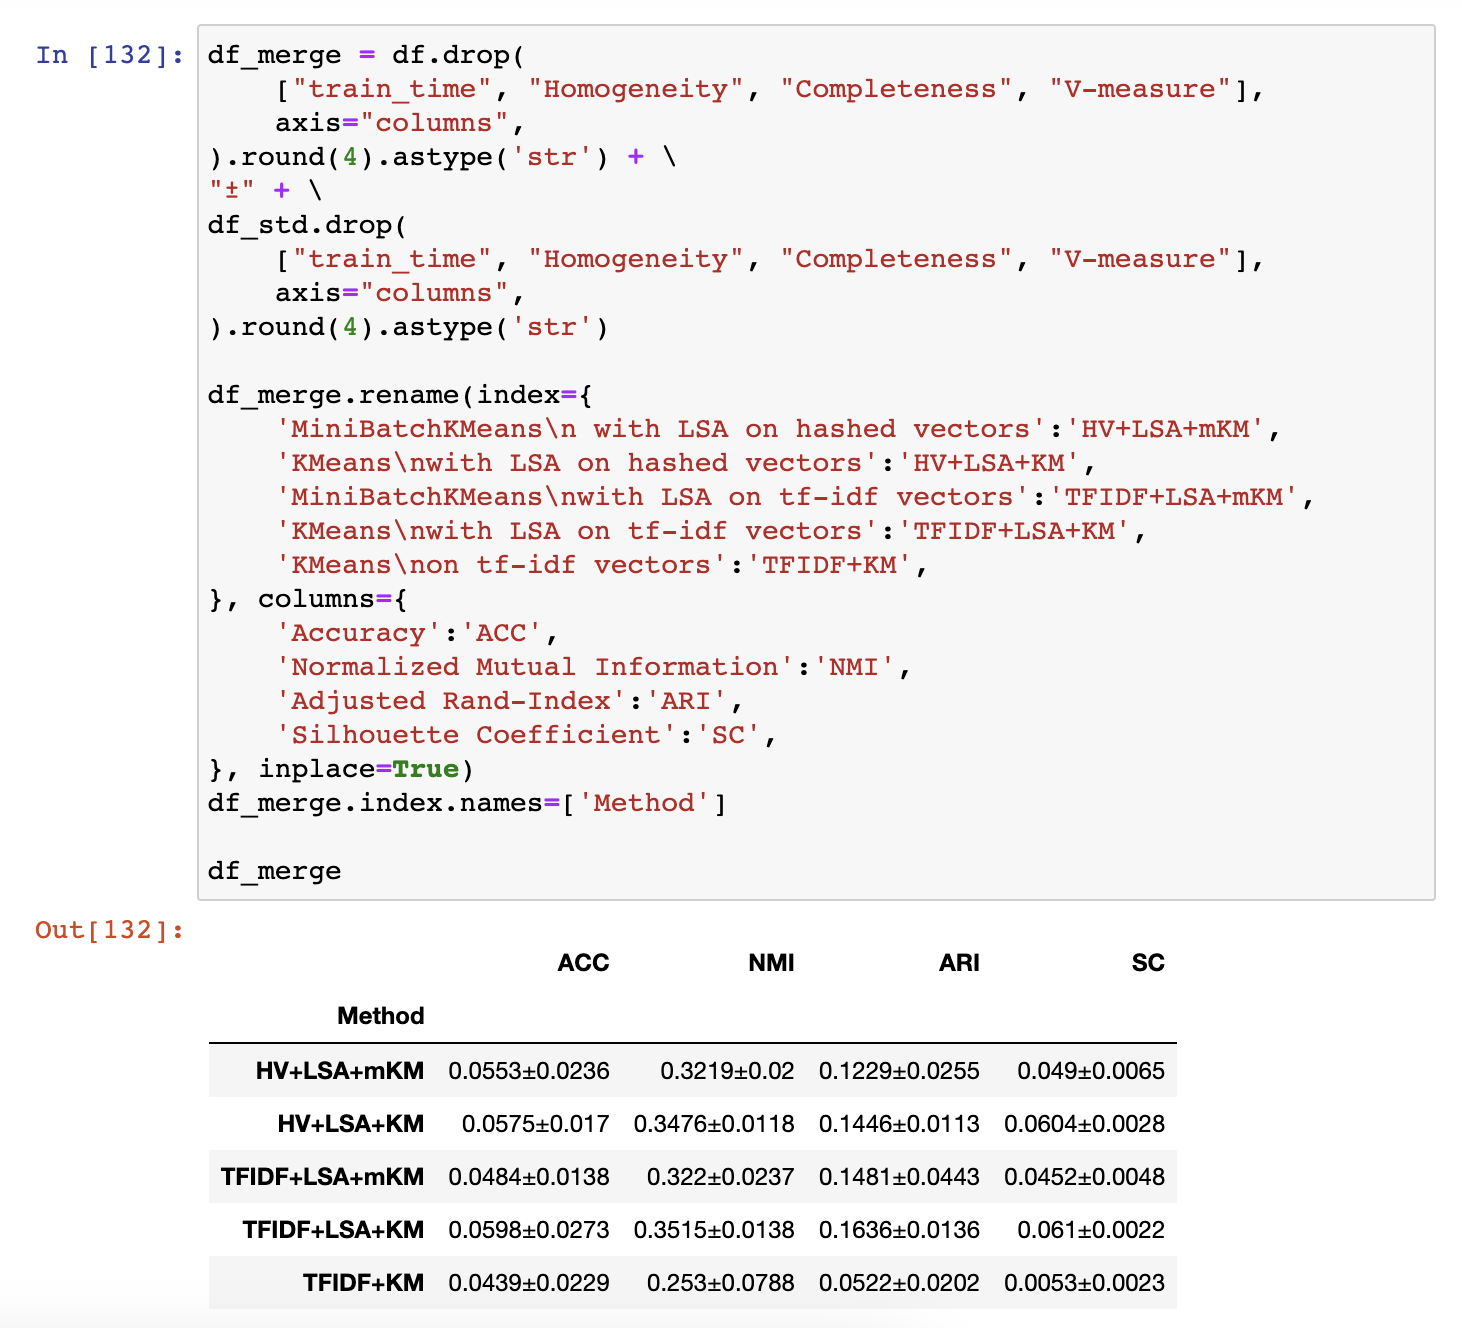

---

이거 클러스터 분류가 정확히 데이터셋 분류랑 순서가 다른거면 어떻게 알지?

---
---

.




### BERT using HuggingFace Transformers

---

> https://velog.io/@jaehyeong/Fine-tuning-Bert-using-Transformers-and-TensorFlow


지금 이거 하고있는데,

https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#autotokenizer

CogLTX 소스코드에도 있는 autotokenizer.from_pretrained()는 정확한 모델명을 적어줘야 하거든? 위 링크에 목록이 나와있는데

소스코드에는 명시 안되어있고 실행할때 입력하도록 되어있음 ㅇㅇ 근데 논문 본문 보면은 다 roberta로 했다고 나와있음 4epoch로 fine-tuning!

결론은 쓸거면 우리도 이걸로 하덩가 하면될듯

---

https://huggingface.co/transformers/v3.5.1/model_doc/bert.html#bertforsequenceclassification

---

이걸로 블로그에서 쓰는 모든 TF를 Pytorch로 대체하는중

---

아 드디어 찾음 이렇게 하면됨

https://huggingface.co/transformers/v3.4.0/custom_datasets.html#sequence-classification-with-imdb-reviews

---

위 링크에서는 DistilBert를 사용했고,
BertForSequenceClassfication의 예제에서는 "textattack/bert-base-uncased-yelp-polarity" 이란걸 사용했음 
이게 sequence classification에 특화해서 파인튜닝된 모델인 것 같으니까 참고

https://huggingface.co/docs/transformers/v4.27.0/en/model_doc/bert#transformers.BertForSequenceClassification.forward.example-2

---

"textattack/bert-base-uncased-yelp-polarity" 링크 

https://huggingface.co/textattack/bert-base-uncased-yelp-polarity

---

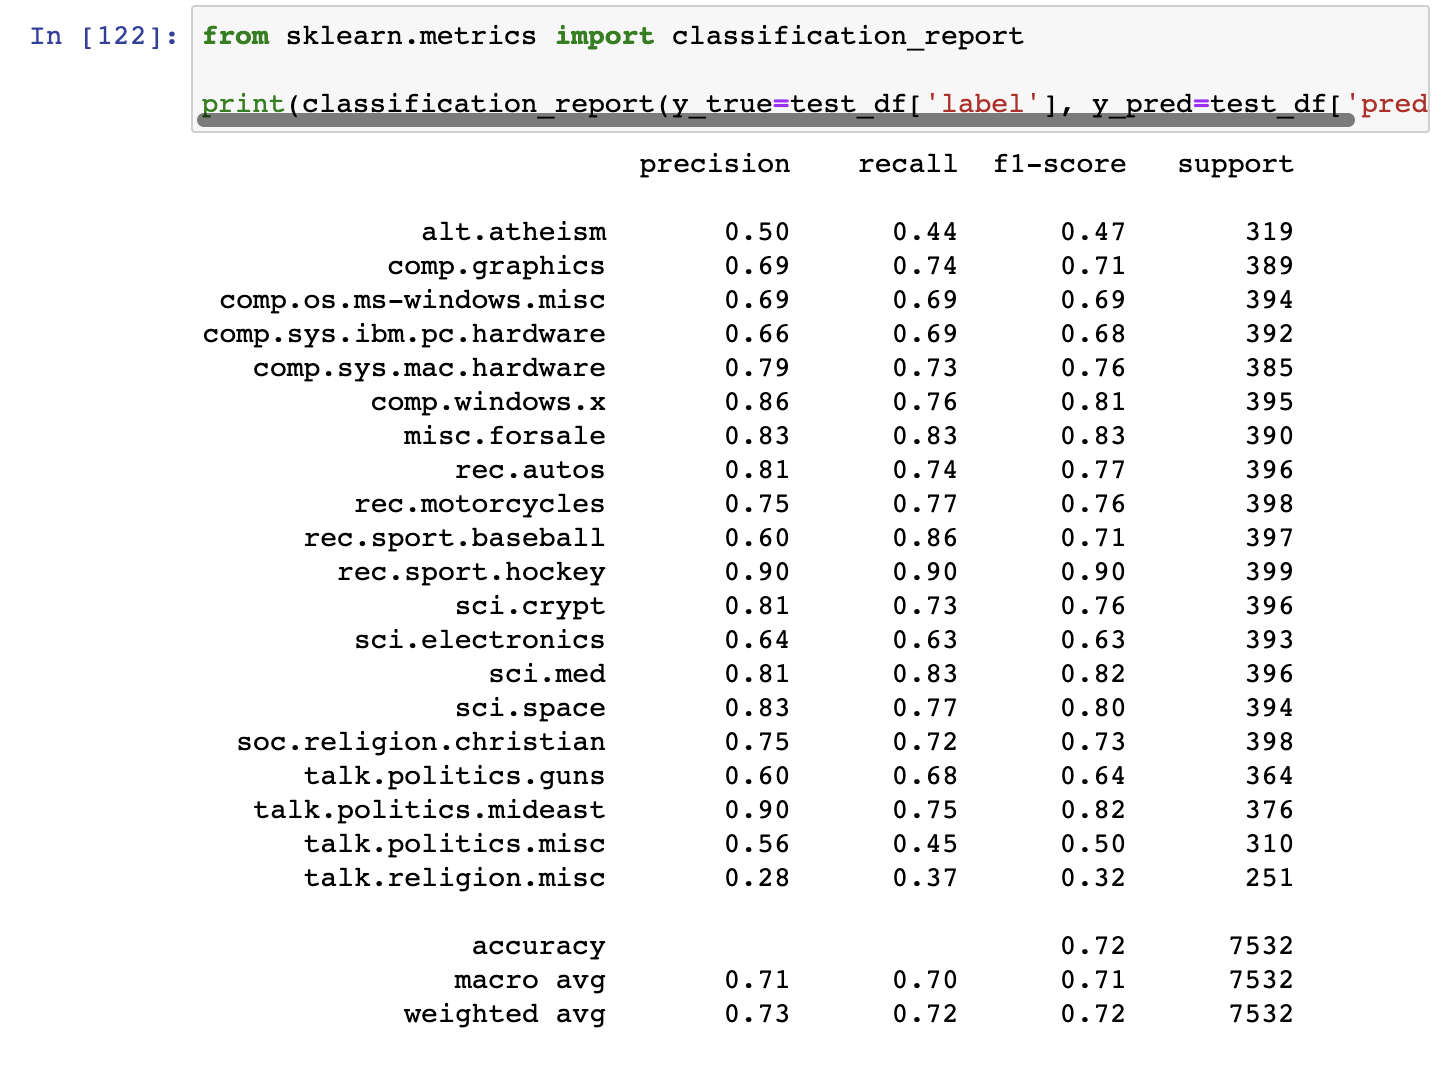

---

어제 하루 학습시키고 여차저차 버그잡아서 겨우 실행 성공함. ACC는 0.7정도로 준수한듯? 근데 이건 Classification인데 이걸 어떻게 Clustering을 한단걸까

tokenizing까지만 하고 그냥 거기다가 KM같은 clustering 알고리즘을 돌린다는건가 tfidf vector 대신해서?